# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 15

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,30,2)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            x=len(img_idx)
            y=120
            z=120
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            cnt_img=0
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                cnt_img+=1
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    norm_image=image/255.0
                    image_resized=resize(norm_image,(120,120),mode='reflect')
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])#normalise and feed in the image
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        cnt_img=0
        batch_cover = num_batches*batch_size
        rem = len(t) - batch_cover
        if(len(t)!=batch_cover):
            for folder in range(rem):
                imgs = os.listdir(source_path+'/'+ t[folder + batch_cover].split(';')[0]) # read all the images in the folder
                cnt_img+=1
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + batch_cover].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    norm_image = image/255.0 # normalizing the image 
                    image_resized=resize(norm_image, (120,120), mode='reflect')
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + batch_size].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15  # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GRU, Dropout, TimeDistributed,Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from keras.layers.convolutional import Conv2D,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from keras.regularizers import l2



In [7]:
def train_model( model):
        # Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.
        train_generator = generator(train_path, train_doc, batch_size)
        val_generator = generator(val_path, val_doc, batch_size)

        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/' #file name
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5' #file path

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1) #chekpoints to save model in .h5
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, cooldown=4, verbose=1,mode='auto',min_delta=0.0001) #learning Rate
        callbacks_list = [checkpoint, LR]

        if (num_train_sequences%batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/batch_size)
        else:
            steps_per_epoch = (num_train_sequences//batch_size) + 1 #in case of remaining data points which are left after full batches

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/batch_size)
        else:
            validation_steps = (num_val_sequences//batch_size) + 1 #in case of remaining data points which are left after full batches
            
        # Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

In [8]:
# plot accuracy & loss graph for training & validation results
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])


In [9]:
def plot_2(history):
    plt.plot(trained_model.history['categorical_accuracy'])
    plt.plot(trained_model.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [10]:
# model 1 - Conv2D layers + GRU Layer

num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15


# Input
input_shape=(frames,120,120,3)

model = Sequential()

model.add(TimeDistributed(Conv2D(num_featuremaps[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(num_featuremaps[1], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(num_featuremaps[2], (3,3),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(num_featuremaps[3], (2,2),padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dense(num_denselayers[0], activation='relu'))
model.add(Dense(num_denselayers[1], activation='relu'))

## using GRU as the RNN model
model.add(GRU(64, return_sequences=False))

# using Softmax as last layer
model.add(Dense(num_classes, activation='softmax')) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 60, 60, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 60, 60, 16)   64        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 30, 30, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 30, 30, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 30, 30, 32)   1

<ipython-input-7-3f6e847af4a5>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
45/45 [==============================] - ETA: 0s - loss: 1.2447 - categorical_accuracy: 0.4948Source path =  ./Project_data/val ; batch size = 15

Epoch 1: val_loss improved from inf to 1.79540, saving model to model_init_2022-06-1422_22_03.018963/model-00001-1.24465-0.49481-1.79540-0.21905.h5
45/45 [==============================] - 142s 3s/step - loss: 1.2447 - categorical_accuracy: 0.4948 - val_loss: 1.7954 - val_categorical_accuracy: 0.2190 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - ETA: 0s - loss: 0.8350 - categorical_accuracy: 0.6963
Epoch 2: val_loss did not improve from 1.79540
45/45 [==============================] - 152s 3s/step - loss: 0.8350 - categorical_accuracy: 0.6963 - val_loss: 2.1227 - val_categorical_accuracy: 0.1619 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - ETA: 0s - loss: 0.6079 - categorical_accuracy: 0.7644
Epoch 3: val_loss did not improve from 1.79540
45/45 [==============================] - 151s 3s/step 

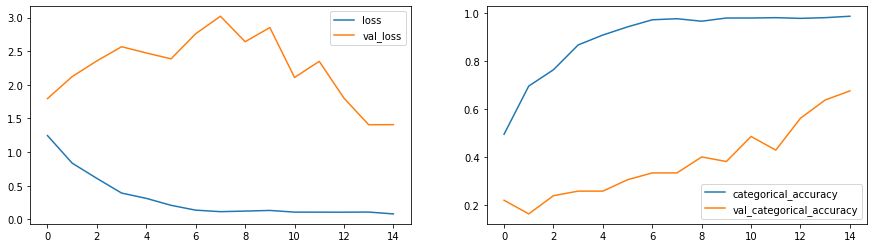

In [11]:
from tensorflow.keras.optimizers import Adam
optimiser = "Adam"#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())
print("Total Params:", model.count_params())
trained_model_1=train_model(model)
plot(trained_model_1)



#### Observation

    Accuracy on tranining set is very high but if we see validations et accuracy it is very low, which is a clear case of overfitting.



## Model 2 : Conv2D layers + GRU Layer+ Adam optimiser + Dropout

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 15, 60, 60, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 15, 60, 60, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 15, 30, 30, 16)   0         
 stributed)                                                      
                                                                 
 dropout (Dropout)           (None, 15, 30, 30, 16)    0         
                                                                 
 time_distributed_16 (TimeDi  (None, 15, 30, 30, 32)   4640      
 stributed)                                           

<ipython-input-7-3f6e847af4a5>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
45/45 [==============================] - ETA: 0s - loss: 1.4564 - categorical_accuracy: 0.3585Source path =  ./Project_data/val ; batch size = 15

Epoch 1: val_loss improved from inf to 1.90634, saving model to model_init_2022-06-1422_22_03.018963/model-00001-1.45638-0.35852-1.90634-0.15238.h5
45/45 [==============================] - 146s 3s/step - loss: 1.4564 - categorical_accuracy: 0.3585 - val_loss: 1.9063 - val_categorical_accuracy: 0.1524 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - ETA: 0s - loss: 1.1734 - categorical_accuracy: 0.4904
Epoch 2: val_loss did not improve from 1.90634
45/45 [==============================] - 144s 3s/step - loss: 1.1734 - categorical_accuracy: 0.4904 - val_loss: 2.2804 - val_categorical_accuracy: 0.1619 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - ETA: 0s - loss: 0.9679 - categorical_accuracy: 0.6104
Epoch 3: val_loss did not improve from 1.90634
45/45 [==============================] - 147s 3s/step 

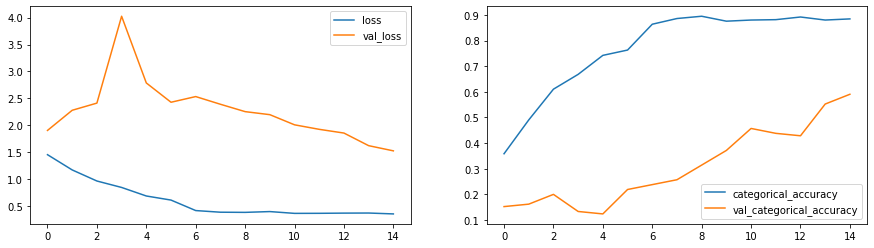

In [12]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout=0.25


# Input
input_shape=(frames,120,120,3)

model2 = Sequential()

model2.add(TimeDistributed(Conv2D(num_featuremaps[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model2.add(Dropout(dropout))

model2.add(TimeDistributed(Conv2D(num_featuremaps[1], (3,3),padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model2.add(TimeDistributed(Conv2D(num_featuremaps[2], (3,3),padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model2.add(Dropout(dropout))

model2.add(TimeDistributed(Conv2D(num_featuremaps[3], (2,2),padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model2.add(TimeDistributed(Flatten()))

model2.add(Dense(num_denselayers[0], activation='relu'))
model2.add(Dense(num_denselayers[1], activation='relu'))
model2.add(Dropout(dropout))

## using GRU as the RNN model
model2.add(GRU(64, return_sequences=False))
model2.add(Dropout(dropout))

# using Softmax as last layer
model2.add(Dense(num_classes, activation='softmax')) 


optimiser = "Adam" #write your optimizer
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model2.summary())


print("Total Params:", model2.count_params())
trained_model_2=train_model(model2)

plot(trained_model_2)



#### observation 
There is not significant improvement with this model. :( 

# model3

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 15, 60, 60, 16)   448       
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 15, 60, 60, 16)   64        
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 15, 30, 30, 16)   0         
 stributed)                                                      
                                                                 
 dropout_4 (Dropout)         (None, 15, 30, 30, 16)    0         
                                                                 
 time_distributed_29 (TimeDi  (None, 15, 30, 30, 32)   4640      
 stributed)                                           

<ipython-input-7-3f6e847af4a5>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
45/45 [==============================] - ETA: 0s - loss: 2.9267 - categorical_accuracy: 0.3556Source path =  ./Project_data/val ; batch size = 15

Epoch 1: val_loss improved from inf to 3.01267, saving model to model_init_2022-06-1422_22_03.018963/model-00001-2.92667-0.35556-3.01267-0.13333.h5
45/45 [==============================] - 157s 4s/step - loss: 2.9267 - categorical_accuracy: 0.3556 - val_loss: 3.0127 - val_categorical_accuracy: 0.1333 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - ETA: 0s - loss: 2.2190 - categorical_accuracy: 0.5304
Epoch 2: val_loss improved from 3.01267 to 2.98502, saving model to model_init_2022-06-1422_22_03.018963/model-00002-2.21900-0.53037-2.98502-0.16190.h5
45/45 [==============================] - 155s 4s/step - loss: 2.2190 - categorical_accuracy: 0.5304 - val_loss: 2.9850 - val_categorical_accuracy: 0.1619 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - ETA: 0s - loss: 1.8846 - categorical_accuracy: 0.5

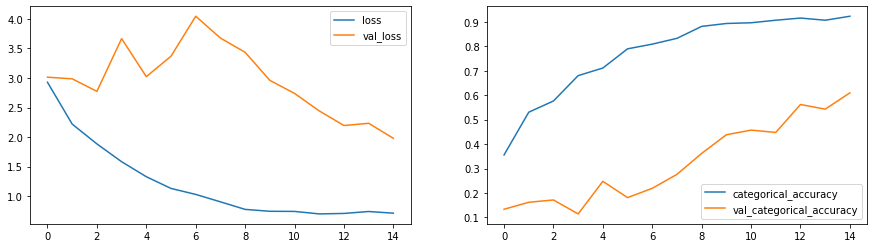

In [13]:
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25

# Input
input_shape=(frames,120,120,3)

model3 = Sequential()

model3.add(TimeDistributed(Conv2D(num_featuremaps[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model3.add(Dropout(dropout))

model3.add(TimeDistributed(Conv2D(num_featuremaps[1], (3,3),padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model3.add(TimeDistributed(Conv2D(num_featuremaps[2], (3,3),padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
model3.add(Dropout(dropout))

model3.add(TimeDistributed(Conv2D(num_featuremaps[3], (2,2),padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model3.add(TimeDistributed(Flatten()))

model3.add(Dense(num_denselayers[0], activation='relu', kernel_regularizer=l2(0.01)))
model3.add(Dense(num_denselayers[1], activation='relu', kernel_regularizer=l2(0.01)))
model3.add(Dropout(dropout))

## using GRU as the RNN model along with softmax as our last layer.
model3.add(GRU(64, return_sequences=False))
model3.add(Dropout(dropout))

# using Softmax as last layer
model3.add(Dense(num_classes, activation='softmax')) 

optimiser = "Adam"#write your optimizer
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model3.summary())

print("Total Params:", model3.count_params())
trained_model_3=train_model(model3)
plot(trained_model_3)



#### observation 
we still see overfitting not of much improvement
USing Conv2D is not giving desired results. 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 15, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 15, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 60, 60, 16)    0         
 )                                                               
                                                                 
 dropout_8 (Dropout)         (None, 7, 60, 60, 16)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 60, 60, 32)    

<ipython-input-7-3f6e847af4a5>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
45/45 [==============================] - ETA: 0s - loss: 5.1022 - categorical_accuracy: 0.2904Source path =  ./Project_data/val ; batch size = 15

Epoch 1: val_loss improved from inf to 7.90182, saving model to model_init_2022-06-1422_22_03.018963/model-00001-5.10216-0.29037-7.90182-0.20952.h5
45/45 [==============================] - 382s 9s/step - loss: 5.1022 - categorical_accuracy: 0.2904 - val_loss: 7.9018 - val_categorical_accuracy: 0.2095 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - ETA: 0s - loss: 3.1291 - categorical_accuracy: 0.3378 
Epoch 2: val_loss did not improve from 7.90182
45/45 [==============================] - 496s 11s/step - loss: 3.1291 - categorical_accuracy: 0.3378 - val_loss: 11.0332 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - ETA: 0s - loss: 2.8950 - categorical_accuracy: 0.3689
Epoch 3: val_loss did not improve from 7.90182
45/45 [==============================] - 473s 11s/s

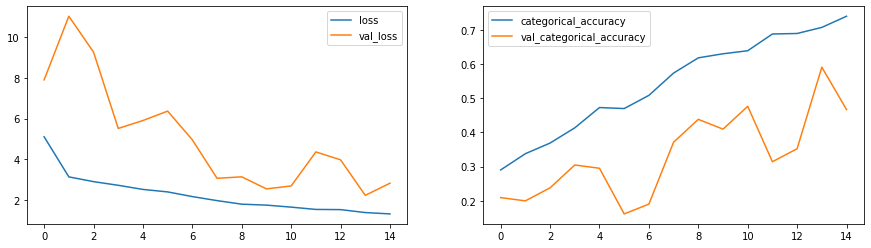

In [14]:
# model 4 
# Let's use Conv3D 
#Conv3D layers + L2 Regularization + Batch Normalization + Dropout 

num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25

# Input
input_shape=(frames,120,120,3)

# Define model
model4 = Sequential()


model4.add(Conv3D(num_featuremaps[0], (3, 3, 3), padding = 'same', input_shape = input_shape))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size = (2, 2, 2)))
model4.add(Dropout(0.25))
          
model4.add(Conv3D(num_featuremaps[1], (2, 2, 2), padding = 'same'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size = (2, 2, 2)))

model4.add(Conv3D(num_featuremaps[2], (2, 2, 2), padding = 'same'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling3D(pool_size = (2, 2, 2)))
model4.add(Dropout(0.25))
          
model4.add(Flatten())
          
model4.add(Dense(num_denselayers[0], activation='relu',kernel_regularizer=l2(0.01)))
model4.add(Dropout(0.25))
          
model4.add(Dense(num_denselayers[1], activation='relu',kernel_regularizer=l2(0.01)))
model4.add(Dropout(0.25))
          

 # using Softmax as last layer
model4.add(Dense(num_classes, activation='softmax'))

optimiser = "Adam" #write your optimizer
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model4.summary())

print("Total Params:", model4.count_params())
trained_model_4=train_model(model4)


plot(trained_model_4)


In [ ]:
#### observation 
 Using Conv3D , didn't give a model which we are expecting. 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_39 (TimeDi  (None, 15, 3, 3, 512)    14714688  
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 15, 3, 3, 512)    2048      
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 15, 1, 1, 512)    0         
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (None, 15, 512)          0         
 stributed)                                                      
                                                                 
 gru_3 (GRU)                 (None, 64)               

<ipython-input-7-3f6e847af4a5>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
45/45 [==============================] - ETA: 0s - loss: 1.6623 - categorical_accuracy: 0.2044 Source path =  ./Project_data/val ; batch size = 15

Epoch 1: val_loss improved from inf to 1.99205, saving model to model_init_2022-06-1422_22_03.018963/model-00001-1.66229-0.20444-1.99205-0.20952.h5
45/45 [==============================] - 1817s 41s/step - loss: 1.6623 - categorical_accuracy: 0.2044 - val_loss: 1.9921 - val_categorical_accuracy: 0.2095 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - ETA: 0s - loss: 1.5253 - categorical_accuracy: 0.2948 
Epoch 2: val_loss did not improve from 1.99205
45/45 [==============================] - 1572s 35s/step - loss: 1.5253 - categorical_accuracy: 0.2948 - val_loss: 2.4136 - val_categorical_accuracy: 0.2381 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - ETA: 0s - loss: 1.4264 - categorical_accuracy: 0.3630 
Epoch 3: val_loss improved from 1.99205 to 1.59762, saving model to model_init_2022-06-1422_22

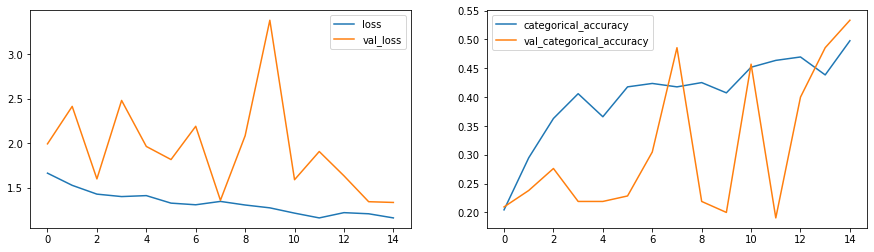

In [15]:
# model 5
# lets use tranfer learning 
# vggnet

from keras.applications.vgg16 import VGG16
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25

# Input
input_shape=(frames,120,120,3)

# Define model
vgg_model = VGG16(weights='imagenet', include_top=False)

model5 = Sequential()
model5.add(TimeDistributed(vgg_model,input_shape=input_shape))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))
model5.add(TimeDistributed(Flatten()))


model5.add(GRU(64, return_sequences=False))
model5.add(Dropout(dropout))

model5.add(Dense(num_denselayers[1], activation='relu'))
model5.add(Dropout(dropout))


model5.add(Dense(num_classes, activation='softmax')) 
optimiser = "Adam" #write your optimizer
model5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model5.summary())

print("Total Params:", model5.count_params())
trained_model_5=train_model(model5)
plot(trained_model_5)

In [ ]:
#### observation 
Using vggnet , we see training and validation accuracy is almost close but overall accuracy is very low. 

17225924/17225924 [==============================] - 2s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_43 (TimeDi  (None, 15, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_44 (TimeDi  (None, 15, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_45 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 15, 1024)         0         
 stributed)                                                      
                                                       

<ipython-input-7-3f6e847af4a5>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
45/45 [==============================] - ETA: 0s - loss: 1.2593 - categorical_accuracy: 0.4667Source path =  ./Project_data/val ; batch size = 15

Epoch 1: val_loss improved from inf to 1.44054, saving model to model_init_2022-06-1422_22_03.018963/model-00001-1.25929-0.46667-1.44054-0.44762.h5
45/45 [==============================] - 386s 8s/step - loss: 1.2593 - categorical_accuracy: 0.4667 - val_loss: 1.4405 - val_categorical_accuracy: 0.4476 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - ETA: 0s - loss: 0.7089 - categorical_accuracy: 0.7422
Epoch 2: val_loss improved from 1.44054 to 1.06796, saving model to model_init_2022-06-1422_22_03.018963/model-00002-0.70885-0.74222-1.06796-0.76190.h5
45/45 [==============================] - 384s 9s/step - loss: 0.7089 - categorical_accuracy: 0.7422 - val_loss: 1.0680 - val_categorical_accuracy: 0.7619 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - ETA: 0s - loss: 0.4973 - categorical_accuracy: 0.8

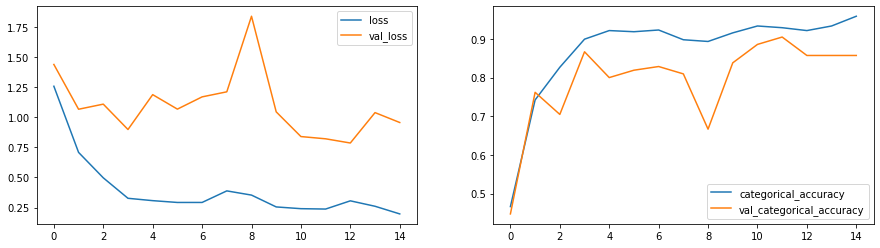

In [16]:
#model 6
# mobilenet

from keras.applications import  mobilenet
num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25


# Input
input_shape=(frames,120,120,3)

# Define model
mobile_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model6 = Sequential()
model6.add(TimeDistributed(mobile_model,input_shape=input_shape))

model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2, 2))))
model6.add(TimeDistributed(Flatten()))

model6.add(GRU(64, return_sequences=False))
model6.add(Dropout(dropout))

model6.add(Dense(num_denselayers[1],activation='relu'))
model6.add(Dropout(dropout))

# using Softmax as last layer
model6.add(Dense(num_classes, activation='softmax')) 

optimiser = "Adam" #write your optimizer
model6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model6.summary())
print("Total Params:", model6.count_params())
trained_model_6=train_model(model6)

plot(trained_model_6)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_47 (TimeDi  (None, 15, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_48 (TimeDi  (None, 15, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 15, 1024)         0         
 stributed)                                                      
                                                                 
 gru_5 (GRU)                 (None, 64)               

<ipython-input-7-3f6e847af4a5>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.2741 - categorical_accuracy: 0.5000 Source path =  ./Project_data/val ; batch size = 20

Epoch 1: val_loss improved from inf to 1.07357, saving model to model_init_2022-06-1422_22_03.018963/model-00001-1.27410-0.50000-1.07357-0.59000.h5
34/34 [==============================] - 428s 13s/step - loss: 1.2741 - categorical_accuracy: 0.5000 - val_loss: 1.0736 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 0.6030 - categorical_accuracy: 0.7706 
Epoch 2: val_loss improved from 1.07357 to 0.73531, saving model to model_init_2022-06-1422_22_03.018963/model-00002-0.60303-0.77059-0.73531-0.74000.h5
34/34 [==============================] - 420s 12s/step - loss: 0.6030 - categorical_accuracy: 0.7706 - val_loss: 0.7353 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.4292 - categorical_accuracy:

34/34 [==============================] - 502s 15s/step - loss: 0.1095 - categorical_accuracy: 0.9779 - val_loss: 0.3007 - val_categorical_accuracy: 0.9200 - lr: 1.0000e-07
Epoch 24/30
34/34 [==============================] - ETA: 0s - loss: 0.1338 - categorical_accuracy: 0.9838 
Epoch 24: val_loss improved from 0.22714 to 0.18956, saving model to model_init_2022-06-1422_22_03.018963/model-00024-0.13383-0.98382-0.18956-0.91000.h5
34/34 [==============================] - 479s 14s/step - loss: 0.1338 - categorical_accuracy: 0.9838 - val_loss: 0.1896 - val_categorical_accuracy: 0.9100 - lr: 1.0000e-07
Epoch 25/30
34/34 [==============================] - ETA: 0s - loss: 0.1363 - categorical_accuracy: 0.9824 
Epoch 25: val_loss did not improve from 0.18956
34/34 [==============================] - 508s 15s/step - loss: 0.1363 - categorical_accuracy: 0.9824 - val_loss: 0.3755 - val_categorical_accuracy: 0.8700 - lr: 1.0000e-07
Epoch 26/30
34/34 [==============================] - ETA: 0s - loss

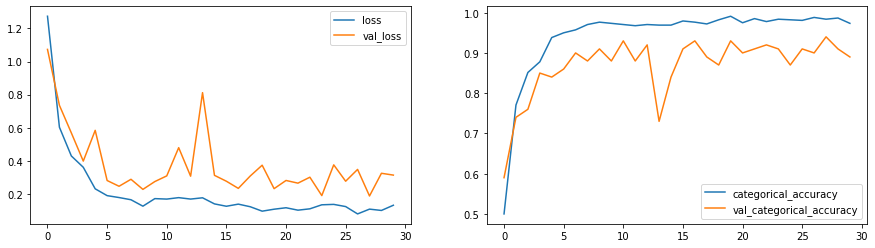

In [17]:
# model 7 
# let's use mobilenet but we will increase epoch and batch size

num_featuremaps = [16,32,64,128]
num_denselayers = [64,32,5]
num_classes = 5
frames = 15
dropout = 0.25
num_epochs = 30

# batch size
batch_size = 20

# Input
input_shape=(frames,120,120,3)

# Define model
mobile_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

model7 = Sequential()
model7.add(TimeDistributed(mobile_model,input_shape=input_shape))

model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
model7.add(TimeDistributed(Flatten()))

model7.add(GRU(64, return_sequences=False))
model7.add(Dropout(dropout))

model7.add(Dense(num_denselayers[1],activation='relu'))
model7.add(Dropout(dropout))

# using Softmax as last layer
model7.add(Dense(num_classes, activation='softmax')) 
optimiser = "Adam" #write your optimizer
model7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Model Summary
print (model7.summary())
print("Total Params:", model7.count_params())
trained_model_7=train_model(model7)
plot(trained_model_7)

### observation 

Increasing the epoch and batch size has improved the model efficenency. Accuracy score and validation score both have increased. 

# Summary


Last model, model7 seems to be working fine with 97% accuracy on traning and 89% on validation. 

We built first model with simple CNN + RNN model and after that we introduced dropouts ,  normaliaztion  in combination of different hyperparameters but result was not satisfactory.

Due to some reason Google Colab GPU was taking way more tim so I ran all experiments on my Mac and due to that epich was kept 15 initially and when I found a working model I increased the number of batch size and epoch.

I could have tried other configurations like exploring other tranfer learning model, some other optimizers like SGD,Adagrad etc but due to limit computational capacity and very long training time I couldn't evaluate those. 


In [20]:
model7.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_47 (TimeDi  (None, 15, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_48 (TimeDi  (None, 15, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 15, 1024)         0         
 stributed)                                                      
                                                                 
 gru_5 (GRU)                 (None, 64)               

In [22]:
model7.save('./final_model.h5')